In [3]:
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
import warnings
warnings.simplefilter(action="ignore", category=FutureWarning)

from urllib.request import urlopen 
import re
def read_url(url): 
    return re.sub('\\s+', ' ', urlopen(url).read().decode())

## Two-way tables

Our first example is motivated by this UChicago news story:

https://news.uchicago.edu/story/does-paying-people-get-vaccinated-increase-vaccination-rates

The corresponding Science article is here:
"Monetary incentives increase COVID-19 vaccinations" Campos-Mercade et al.  Science 7 October 2021.  https://www.science.org/doi/10.1126/science.abm0475

**Figure 1 from the paper:**

<div>
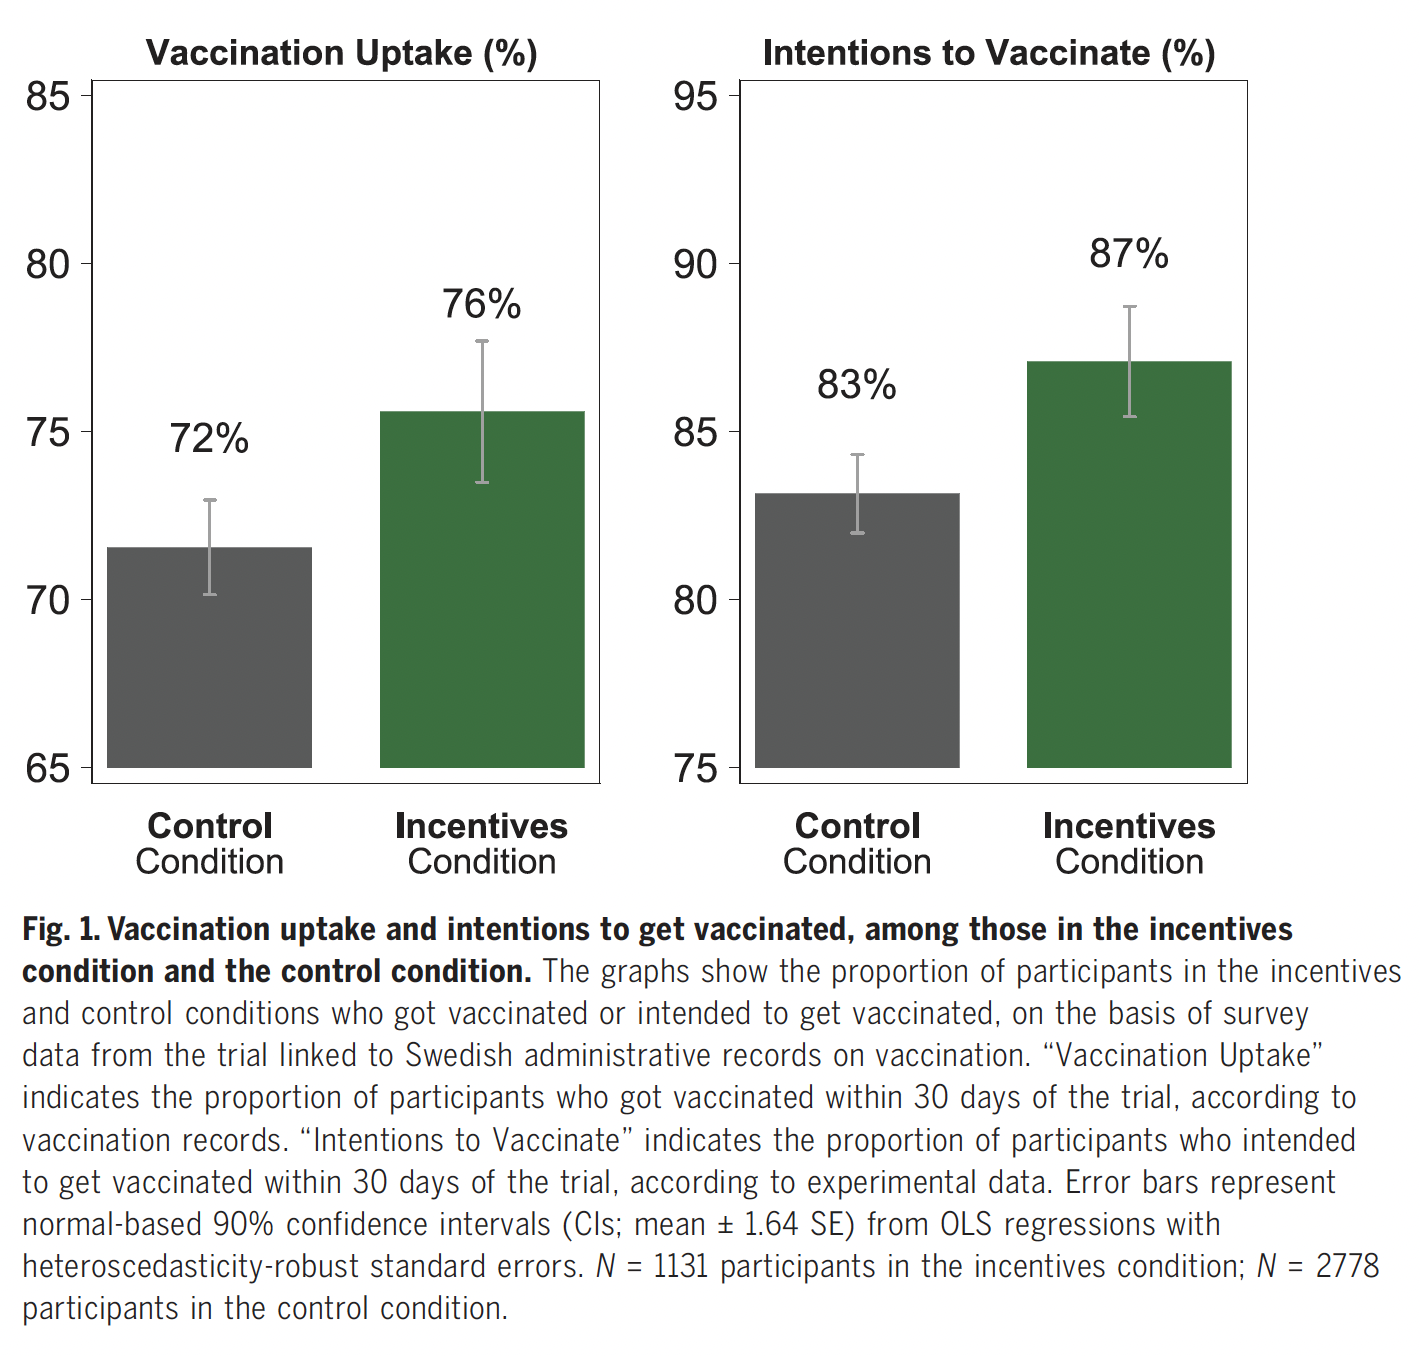
</div>


<br> 

Briefly:
-  Pregistered randomized controlled trial
-  8286 participants in Sweden
-  incentives and nudges for increasing vaccination rates (e.g., 24 US dollars)
-  monetary incentives lead to increase of 4.2%  (p=0.005)
-  no evidence that behavioral nudges work (examples: subjects in one group were asked to make a list of people in their lives who would benefit from the participant being vaccinated; other group, to take a quiz detailing the benefits of COVID-19 vaccines)

**Should US use monetary incentives? Discuss:**


A perspective on the article: Nancy S. Jeker Cash incentives, ethics, and COVID-19 vaccination Science.  Nov 11 2021.
https://www.science.org/doi/full/10.1126/science.abm6400
        
        

We will try to reproduce the analysis in the above figure. Data are available here: https://zenodo.org/record/5529626

The authors provide the data in STATA formatted files. We used the `haven` library in R to export the main data file into a .csv format. Note that we could not find a data dictionary so we had to guess on what some of the variables mean.  There are so many fields that most must come from participant surveys.

In [4]:
df1=pd.read_csv('data/monetize.csv')
df1.head(5)

FileNotFoundError: [Errno 2] No such file or directory: 'data/monetize.csv'

In [ ]:
df1.shape

In [ ]:
df1.describe()

In [ ]:
# some detective work
[8286*0.136495,8286*0.335264]

In [ ]:
df1.describe().loc["mean"].head(7)* 8286

We can decode some of this by reconciling with Figure S1 in the paper:
Control (2778), Incentives (1131), Social impact (1114), 
Information (1078), Arguments (1076) and No reminders (1109)
Nudge is apparently the sum of the non-monetary treatments
(social impact, information and arguments) 1114+1078+1076=3268.

In [ ]:
1114+1078+1076

In [ ]:
# extract the data frame with some colums for just the subjects 
# in the incentive and control conditions 1131+2778=3909 subjects 
df2=df1[(df1.treat_pay==1)|(df1.control==1)][['treat_pay','control',\
    'intention1','vaccinated','female','age','unemployed']]
df2.sample(10)

In [ ]:
df2.groupby('control').mean()

In [ ]:
# I can't stop myself from making a histogram here
df2.hist("age")
# Hmmm.  Cuts off pretty sharply before 50.  I'm sure they said
# that in the paper.

In [ ]:
df2.groupby('control').intention1.count()

In [ ]:
df2.groupby('control').sum()

In [ ]:
# this is different than 4.2!
df2.groupby('control').mean().vaccinated.iloc[0]-\
df2.groupby('control').mean().vaccinated.iloc[1]

In [ ]:
# Let me make sure I know the underlying numbers
855 /1131  , 1988 / 2778

In [ ]:
df2.groupby(['control','female']).mean()

In [ ]:
# a complicated way to construct the two-way table 
pd.pivot_table(df2, index= 'vaccinated', values= ['control','treat_pay'],aggfunc='sum')

Perform the following hypothesis test

$H_0$: no difference in vaccination rates between treatment and controls

$H_A$: there is a difference in vaccination rates

Test statistics: $D=\hat p_T - \hat p_C$ (observed is 4.03%)

Distribution of $D$ under the null hypothesis?

In [ ]:
# this an alternative to using the sample function in the pandas df environment
np.random.permutation([11,3,3,4,7])

In [ ]:
control=df2.control.values
vaccinated=df2.vaccinated.values
shuffled_control=np.random.permutation(control)
shuffled_prop=pd.DataFrame({"vaccinated":vaccinated,
                              "Shuffled Controls":shuffled_control})\
                .groupby(["Shuffled Controls"]).mean()
shuffled_prop

In [ ]:
# collect the results from nsim shuffles 
# input are the two arrays that contain info on the two variables
# for simplicity, they are named similar to above
def repeatedshuffle(xcontrol,yvaccinated,nsim):
    outcomes = np.array([])
    for i in np.arange(nsim):
        shuffled_control=np.random.permutation(xcontrol)
        shuffled_prop=pd.DataFrame({"vaccinated":yvaccinated,
                      "Shuffled Controls":shuffled_control})\
                      .groupby(["Shuffled Controls"]).mean()
        outcomes = np.append(outcomes, shuffled_prop.iloc[0]-shuffled_prop.iloc[1])
    return outcomes


In [ ]:
# 10000 simulated differences
results=repeatedshuffle(control,vaccinated,10000)

In [ ]:
plt.hist(results,bins=25)
plt.scatter(4.034542, -40, color='purple', s=100)
plt.show()

In [ ]:
sum(results>=4.034542), len(results)

In [ ]:
# All code and data for reproducing tables and figures in the manuscript and the supplementary materials can be accessed through the following link: https://doi.org/10. 5281/zenodo.5529625


In [ ]:
fig, ax = plt.subplots()
ax.bar([0,1], [0.7559681697612732, 0.7156227501799856])
ax.set_xticks([0,1],labels=["Incentives\ncondition", "Control\ncondition"])
ax.set_ylim([0.65, 0.8])

In [ ]:
fig, ax = plt.subplots()
ax.bar([0,1], [0.7559681697612732, 0.7156227501799856])
ax.set_xticks([0,1],labels=["Incentives\ncondition\nN=1131", "Control\ncondition\nN=2778"])
ax.set_ylim([0.65, 0.8])
ax.set_title("Fake error bars")
ax.errorbar([0,1], [0.7559681697612732, 0.7156227501799856], 
            yerr=[0.05, 0.05], fmt=".", color="black")

In [ ]:
fig, ax = plt.subplots()
ax.bar([0,1], [0.7559681697612732, 0.7156227501799856])
ax.set_xticks([0,1],labels=["Incentives\ncondition", "Control\ncondition"])
ax.set_ylim([0.65, 0.82])
ax.errorbar([0,1], [0.7559681697612732, 0.7156227501799856], 
            yerr=[0.05, 0.05], fmt=".", color="black", capsize=14)
plt.title("Two numbers, fake errorbars")
plt.ylabel("Vaccine uptake")

In [ ]:
# How to draw error bars?   A: Sort data, take most extreme 2.5%??

# Sorting the data doesn't work great for us, our data are 1s and 0s:
plt.plot(np.sort(df2.query("control==1"). vaccinated))

# The thing we would need to sort is the collection of statistics 
# (vax proportions) from bootstrap (or permutation) samples

In [ ]:
# Incentives   Control
# 855 /1131  , 1988 / 2778
# (0.7559681697612732, 0.7156227501799856) 


In [ ]:
# CALCULATE ERROR BARS HERE  (Standard error of the mean, binomial 
# random variable...) 

1.  **Standard error approach**.  Approximate the binomial distribution with a normal distribution and use standard error of the mean.  Works only when min(Np, N(1-p)) >=30.  

* The standard deviation of a binomial variable  (X successes) 
is   $\sqrt{ p(1-p) N}  $

* The standard deviation of a binomial proportion (X/N) 
is $ \sqrt{ p (1-p) \over N} $ 

2. **Bootstrap or permutation approach**  Generate collection of resampled versions, describe the locations of the tails of the distribution of "randomized" resamples.

3. **Math**   The beta distribution with a=855+1 and b=1131-855+1 gives the posterior probability density for the proportion $p$ consistent with 855/1131 successes.  This can be interrogated with library functions for .ppf() to get confidence bounds.

### Standard error (of the binomial) approach: 

In [ ]:
errorbar_control = 1.96 * np.sqrt( 0.7156227501799856 * 
                                  (1-0.7156227501799856) /2778 ) 
errorbar_treatment = 1.96 * np.sqrt( 0.7559681697612732 * 
                                    (1-0.7559681697612732) /1131 )  
errorbar_control, errorbar_treatment

In [ ]:
fig, ax = plt.subplots()
ax.bar([0,1], [0.7559681697612732, 0.7156227501799856])
ax.set_xticks([0,1],labels=["Incentives\ncondition\nN=1131", "Control\ncondition\nN=2778"])
ax.set_ylim([0.65, 0.82])
ax.errorbar([0,1], [0.7559681697612732, 0.7156227501799856], 
            yerr=[errorbar_treatment, errorbar_control], fmt=".", color="black", capsize=14)
plt.title("Vaccine uptake in Swedish\n incentive experiment")
plt.ylabel("Vaccine uptake")

# More toy samples ?! 

In [ ]:
def plot_some_dots(means, errorbars, truemean, title="Title"):
    '''plots dot plot with means on y, error bars on y of width
    errorbars, and a line at the value truemean.  If the errorbars
    fail to contain truemean, the dot plot is overwritten with 
    red errorbars.'''
# These two lines test that the inputs are of the right shape
    assert len(means) == len(errorbars) # Must provide one errorbar for each mean
# plot all the dots black
    plt.figure(figsize=(12,4))
    plt.errorbar(range(len(means)), means, errorbars, fmt=".k", capsize=5, ecolor="black", linewidth=3)
# find the points that contain the true mean
    outsideindexes = np.where( (means - errorbars > truemean ) | 
                               (means + errorbars < truemean ))[0]  
    outsidemeans = means[outsideindexes]
    outsidebars = errorbars[outsideindexes]
# plot some of the dots red:
    plt.errorbar(outsideindexes, outsidemeans, outsidebars, fmt=".k", capsize=5, ecolor="red", linewidth=3)
    plt.plot([0, len(means)], [truemean, truemean], color="yellow")
    plt.xlabel("Sample")
    plt.title(title)
    print(len(outsidebars), "fail to contain the true mean")

In [ ]:
plot_some_dots(np.random.normal(size=100), 
               np.random.uniform(size=100)*5, 0,
              title="Some random dots with random error bars")


In HW06 we generated samples of size 30 from a normal distribution and
made some plots of the sample means and confidence intervals whose
widths were proportional to the sample standard deviations.  Here we 
ask you to repeat this calculation for a sample size of 3.

**Question 1.**
Generate 100 "samples" of size 3 from a Normal(10,4) distribution.
Calculate 100 sample means and 100 sample standard deviations.
Produce a dot plot of the means with error bars of size 1.96 * sample_standard_deviation.
Note that the error bars will, in general, all be different sizes.

**Question 2.**
What fraction of the time do the 1.96 sample standard deviation error bars contain
the true mean?   (Note that this is a binomial random variable / 100).  
If this is not about 5%, we have not drawn the error bars correctly.  


Numpy is built to do things repetitively.  Want to do something to 100,000 of your favorite numbers?  Numpy also doesn't mind organizing numbers into two-dimensional arrays...

In [ ]:
#  10.9% of the time is not 5% of the time.
